# Classifying Potentially Hazardous Asteroids 🌍☄️
*Individual Take-Home Assignment in Machine Learning*

**Student:** Anna-Maria Reidel <br>
**Program:** MAAI <br>
**Date:** 12/25

---

## Problem setting & motivation

I have always been fascinated by space, partly because it is beautiful, partly because it is chaotic, and partly because I love the idea that there are gigantic rocks zooming around the Solar System! <br>
There is something oddly comforting about all the uncertainty up there. But at the same time... wouldn't it be kind of nice if we had some idea which of those rocks might one day get a bit too close for comfort? <br>
NASA actually tracks thousands of near-Earth objects (NEOs)! <br>
So, for this project I have decided to build a classification model that predicts whether an asteroid is labeled as **“potentially hazardous”** based on its physical and orbital characteristics (e.g., estimated diameter, relative velocity, minimum distance to Earth). <br>
Why does this matter? Because astronomers have limited time and telescope access, so if machine learning can help prioritize which objects deserve additional attention, that is a win for sure! 

## Dataset Information

This analysis uses the **NASA Nearest Earth Objects (NEO) dataset**,
publicly available on **Kaggle**:

**Source:**
Vani, S. (2020). *NASA Nearest Earth Objects (NEO) Dataset*.
Kaggle. https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects



## Project roadmap

To keep things organized, I structured the notebook as follows:

1. **Data understanding & cleaning**
   Quick look at the dataset, variables, and class balance.

2. **Exploratory data analysis (EDA)**
   Distributions, simple relationships, and first intuition about what might make an asteroid hazardous.

3. **Modeling**
   Training and tuning two classification models (a simple baseline and a more flexible model).

4. **Model evaluation & comparison**
   Using accuracy, confusion matrices, ROC/AUC, and class-specific metrics.

5. **Discussion & conclusion**
   Findings, which model would I actually trust for this task, and why?


## 1. Data understanding & cleaning

Before jumping into any fancy models, it is important to get a good feeling of what this dataset actually looks like.

How many observations are there?
What types of variables are included?
And most importantly: how imbalanced is the "hazardous" class (spoiler: very)?



In [1]:
import pandas as pd

# first things first: loading the dataset
df = pd.read_csv("neo_v2.csv")
df.head(5)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [2]:
df.shape

(90836, 10)

In [3]:
df.isna().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [4]:
df.dtypes

id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
orbiting_body          object
sentry_object            bool
absolute_magnitude    float64
hazardous                bool
dtype: object

In [5]:
df['hazardous'].value_counts()

hazardous
False    81996
True      8840
Name: count, dtype: int64

In total, the dataset contains **90,836 observations** and **10 variables**, which is more than enough data to train reliable classification models. Most features are numerical (e.g., estimated diameter, miss distance, velocity), with a few object/boolean columns such as orbiting_body and sentry_object. This structure is perfect for the type of ML models I will be using later.

As expected, the hazardous label is highly imbalanced:
about **81,996 asteroids are non-hazardous**, while only **8,840** are labeled **hazardous**.
So roughly **1 in 10** objects is considered “potentially dangerous”, which makes sense, NASA would hopefully not be tracking 90,000 death rocks flying at us.

This imbalance means that plain accuracy could be misleading (a model could predict “not hazardous” all the time and still be 90% accurate).
So later, I will rely more on **ROC/AUC, precision-recall, and confusion matrices** to fairly evaluate the models.



## 2. Exploratory Data Analysis (EDA)

Now, it is time to get a bit more curious!

In this section I will:
- look at basic distributions of the main numerical variables,
- check simple correlations,
- explore how these features differ between hazardous and non-hazardous asteroids

The **goal** here is to get a glimpse into what (hence which features) make an asteroid more likely to be labled as hazardous.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
numeric_cols = [
    "est_diameter_min",
    "est_diameter_max",
    "relative_velocity",
    "miss_distance",
    "absolute_magnitude"
]

df[numeric_cols].describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


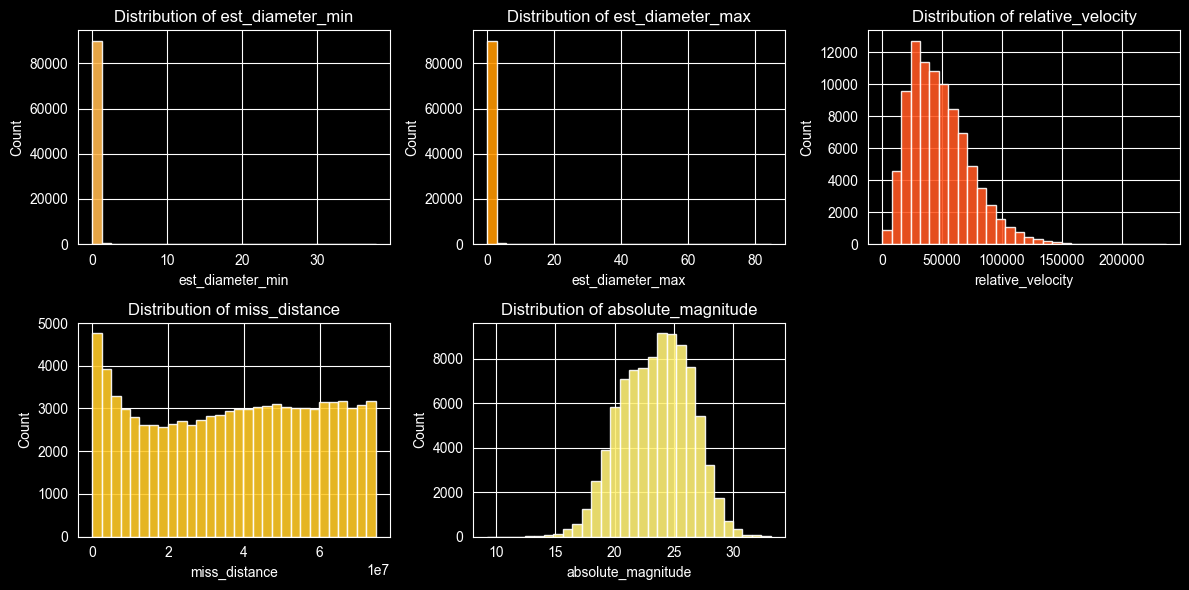

In [8]:
# looking at the numeric feature's distributions
import math
import matplotlib.pyplot as plt

n_cols = 3
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    facecolor="black"
)

axes = axes.flatten()

space_colors = ["#ffb74d", "#ff9800", "#ff5722", "#ffca28", "#fff176", "#fbc02d"]

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    color = space_colors[i % len(space_colors)]

    ax.hist(df[col], bins=30, color=color, edgecolor="white", alpha=0.9)
    ax.set_title(f"Distribution of {col}", color="white")
    ax.set_xlabel(col, color="white")
    ax.set_ylabel("Count", color="white")

    ax.tick_params(colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")

    ax.set_facecolor("black")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Both **est_diameter_min** and **est_diameter_max** are very right-skewed. This makes sense as most asteroids are probably teeny tiny, but with a few large ones creating the long tails (which can be seen from the maximum values in the describe() chunk above as well). The true size of the asteroid lies somewhere in the interval given by these two variables. Hazardous asteroids tend to be larger, so the features are meaningful for the upcoming modeling.

The **relative velocity** distribution is also right-skewed, but with a clearer peak. Most objects travel in a certain speed range, with a few very fast outliers.

The **miss distance** is spread across a wide range. Conceptually, I would expect small miss distances to be strongly associated with the "hazardous" label.

The **absolute magnitude** looks much more bell-shaped and concentrated around a central value. This is the most well-behaved feature statistically and is unlikely to cause numerical issues for most algorithms.

Overall, the plots confirm that the data is **heavily skewed** in several places. In theory, one could manually apply log-transformations to make these distributions more symmetric. Tree-based models don’t mind skewness at all, but linear and distance-based models are a bit more sensitive to it. So later, when I start building models like logistic regression, I will make sure to stabilise the features with proper scaling using a StandardScaler. Still, it’s good to know that log-transforming would have been another valid option here to make the distributions less extreme.





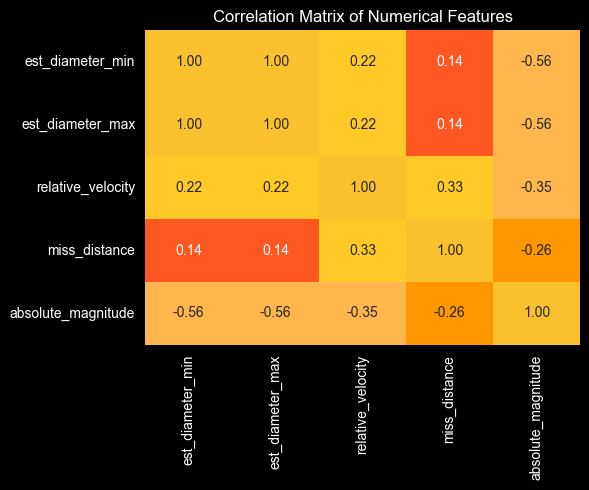

In [9]:
# correlations of features

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

space_colors = ["#ffb74d", "#ff9800", "#ff5722", "#ffca28", "#fff176", "#fbc02d"]

corr = df[numeric_cols].corr()

plt.figure(figsize=(6, 5), facecolor="black")
ax = plt.gca()

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap=ListedColormap(space_colors),
    cbar=False,
    ax=ax
)

ax.set_title("Correlation Matrix of Numerical Features", color="white")
ax.set_facecolor("black")
ax.tick_params(colors="white")

for spine in ax.spines.values():
    spine.set_color("white")

plt.tight_layout()
plt.show()

**est_diameter_min** and **est_diameter_max** are perfectly collinear!
This means I should drop one of them for accurate modeling.
Tree-based models would not suffer from this, but linear or logistic models
could become unstable due to the redundancy.

The other correlations are moderate and look fine to me.


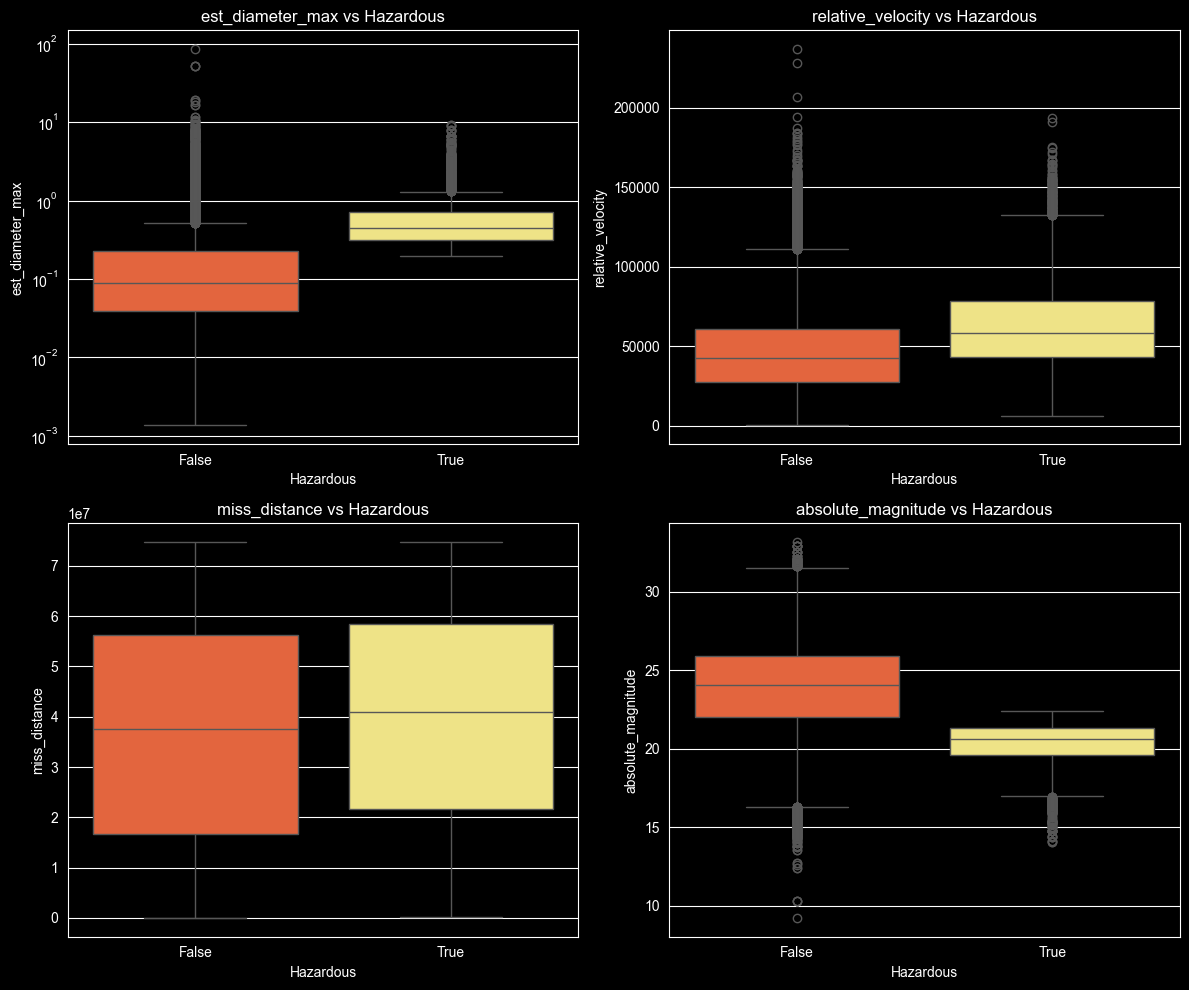

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

space_colors = ["#ffb74d", "#ff9800", "#ff5722", "#ffca28", "#fff176", "#fbc02d"]
haz_palette = {False: space_colors[2], True: space_colors[4]}  # map False/True to colors

numeric_cols = ["est_diameter_max", "relative_velocity", "miss_distance", "absolute_magnitude"]

n_cols = 2
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10), facecolor="black")
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]

    sns.boxplot(
        data=df,
        x="hazardous",
        hue="hazardous",          # put the target on the x-axis
        y=col,
        palette=haz_palette,    # color by False/True on x-axis
        ax=ax
    )

    if col == "est_diameter_max":
        ax.set_yscale("log")

    if ax.get_legend() is not None:
        ax.get_legend().remove()

    ax.set_title(f"{col} vs Hazardous", color="white")
    ax.set_xlabel("Hazardous", color="white")
    ax.set_ylabel(col, color="white")
    ax.set_facecolor("black")
    ax.tick_params(colors="white")

    for spine in ax.spines.values():
        spine.set_color("white")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Correlation of each feature with hazardous (1 = hazardous):
relative_velocity     0.191185
est_diameter_max      0.183363
miss_distance         0.042302
absolute_magnitude   -0.365267
Name: hazardous_int, dtype: float64


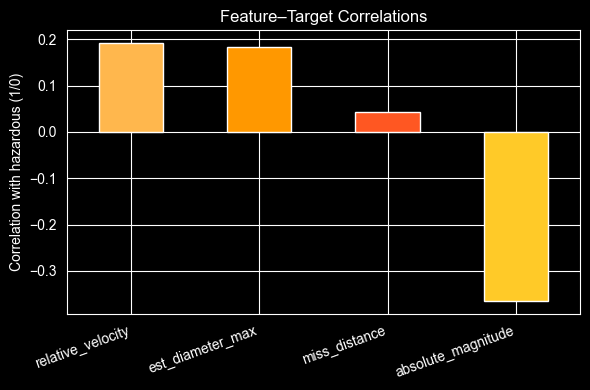

In [11]:
# correlation of features with the target "hazardous"

df_corr = df.copy()
df_corr["hazardous_int"] = df_corr["hazardous"].astype(int)

feature_cols = ["est_diameter_max",
                "relative_velocity",
                "miss_distance",
                "absolute_magnitude"]

corr_to_target = (
    df_corr[feature_cols + ["hazardous_int"]]
    .corr()["hazardous_int"]
    .drop("hazardous_int")
    .sort_values(ascending=False)
)

print("Correlation of each feature with hazardous (1 = hazardous):")
print(corr_to_target)

# barplot of it
import matplotlib.pyplot as plt

space_colors = ["#ffb74d", "#ff9800", "#ff5722", "#ffca28", "#fff176", "#fbc02d"]

plt.figure(figsize=(6, 4), facecolor="black")
corr_to_target.plot(kind="bar", color=space_colors[:len(corr_to_target)])
plt.title("Feature–Target Correlations", color="white")
plt.ylabel("Correlation with hazardous (1/0)", color="white")
plt.xticks(rotation=20, ha="right", color="white")
plt.yticks(color="white")

ax = plt.gca()
ax.set_facecolor("black")
for spine in ax.spines.values():
    spine.set_color("white")

plt.tight_layout()
plt.show()


### 💫 Conclusion for Modeling

From these boxplots and the correlations of features and target, it becomes pretty clear what the model will rely on:
Hazardous asteroids tend to be **larger**, **faster**, **brighter**, and pass **closer** to Earth.
The differences are especially visible for size and brightness, while miss distance and velocity show slightly more overlap. <br> Absolute_magnitude is my strongest feature here with the highest correlation of about -0.37 and a boxplot that does an amazing job at separating the two classes.

This gives me a nice first intuition:
> big + bright + fast + close = more likely to be labeled hazardous.

These relationships will help the models later (especially tree-based ones), and they also tell me that scaling will matter for algorithms like logistic regression. Overall, the predictors look informative and ready for modeling. 🚀

(Quick and important note here: **absolute magnitude** uses a reverse scale: lower values mean a brighter and often larger asteroid)


## 3. Modeling

For the classification task, I decided to train and tune two algorithms that make sense for this type of tabular numerical dataset:

1. **Logistic Regression** as a simple and interpretable baseline model that will serve as a reference point. It requires feature scaling and handles linear decision boundaries well.

2. **Random Forest Classifier** as a nonlinear ensemble method that can capture complex patterns, handle skewed features, and should be pretty robust for this kind of dataset. As I mentioned above, it does not require scaling.

In [12]:
# logistic regression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# defining features X and target y
feature_columns = [
    "est_diameter_max",
    "relative_velocity",
    "miss_distance",
    "absolute_magnitude",
    "sentry_object"
]

X = df[feature_columns].copy()
y = df["hazardous"].astype(int)   # 0 = not hazardous, 1 = hazardous

# train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

logit_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000,
        random_state=42
    )
)

# fitting the model
logit_model.fit(X_train, y_train)
print("\nLogistic regression model fitted:")

# predictions on the test set
y_pred = logit_model.predict(X_test)
y_proba = logit_model.predict_proba(X_test)[:, 1]

# evluations
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest accuracy: {acc:.3f}")
print("\nConfusion matrix (rows=true, cols=predicted):")
print(cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred))


Train shape: (63585, 5)
Test shape : (27251, 5)

Logistic regression model fitted:

Test accuracy: 0.903

Confusion matrix (rows=true, cols=predicted):
[[24394   205]
 [ 2438   214]]

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     24599
           1       0.51      0.08      0.14      2652

    accuracy                           0.90     27251
   macro avg       0.71      0.54      0.54     27251
weighted avg       0.87      0.90      0.87     27251



In [13]:
# logitic regression hyperparamter tuning

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

logit_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000,
        random_state=42
    )
)

# C is regularization strength
# class_weight is to handle class imbalance or not
logit_param_grid = {
    "logisticregression__C": [0.1, 1, 10],
    "logisticregression__class_weight": [None, "balanced"]
}

logit_grid = GridSearchCV(
    estimator=logit_pipe,
    param_grid=logit_param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0
)

logit_grid.fit(X_train, y_train)

print("Best params (logit):", logit_grid.best_params_)
print("Best CV AUC (logit):", logit_grid.best_score_)

# telling it to use the best tuned model
logit_best = logit_grid.best_estimator_

y_pred_logit = logit_best.predict(X_test)
y_proba_logit = logit_best.predict_proba(X_test)[:, 1]

acc_logit = accuracy_score(y_test, y_pred_logit)
cm_logit = confusion_matrix(y_test, y_pred_logit)
auc_logit = roc_auc_score(y_test, y_proba_logit)

print(f"\nTuned Logistic Regression – test accuracy: {acc_logit:.3f}")
print(f"Tuned Logistic Regression – test AUC: {auc_logit:.3f}")
print("\nConfusion matrix (rows=true, cols=predicted):")
print(cm_logit)

print("\nClassification report:")
print(classification_report(y_test, y_pred_logit))


Best params (logit): {'logisticregression__C': 0.1, 'logisticregression__class_weight': None}
Best CV AUC (logit): 0.8781660675315809

Tuned Logistic Regression – test accuracy: 0.903
Tuned Logistic Regression – test AUC: 0.879

Confusion matrix (rows=true, cols=predicted):
[[24416   183]
 [ 2456   196]]

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     24599
           1       0.52      0.07      0.13      2652

    accuracy                           0.90     27251
   macro avg       0.71      0.53      0.54     27251
weighted avg       0.87      0.90      0.87     27251



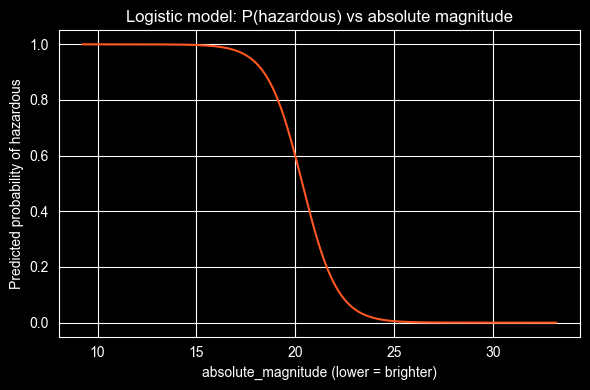

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feat = "absolute_magnitude"

x_vals = np.linspace(df[feat].min(), df[feat].max(), 200)

X_curve = pd.DataFrame({
    "est_diameter_max": df["est_diameter_max"].median(),
    "relative_velocity": df["relative_velocity"].median(),
    "miss_distance": df["miss_distance"].median(),
    "absolute_magnitude": x_vals,
    "sentry_object": df["sentry_object"].mode()[0]
})

p_curve = logit_best.predict_proba(X_curve)[:, 1]

space_colors = ["#ffb74d", "#ff9800", "#ff5722", "#ffca28", "#fff176", "#fbc02d"]

plt.figure(figsize=(6, 4), facecolor="black")
ax = plt.gca()

ax.plot(x_vals, p_curve, color=space_colors[2])
ax.set_title("Logistic model: P(hazardous) vs absolute magnitude", color="white")
ax.set_xlabel("absolute_magnitude (lower = brighter)", color="white")
ax.set_ylabel("Predicted probability of hazardous", color="white")
ax.set_facecolor("black")
ax.tick_params(colors="white")
for spine in ax.spines.values():
    spine.set_color("white")

plt.tight_layout()
plt.show()


The curve makes the model’s behavior super clear: for bright objects (low
absolute magnitude), the logistic model is almost fully convinced they are
hazardous, and for faint objects the probability drops to basically zero.
Around magnitude 20–22 the curve flips sharply, which matches both the data and
the thresholding concept we learned in class: a steeper slope means the
model assigns a strong weight to this feature. So the model really does rely on
brightness as its main signal.


For the Random Forest, I will tune three core hyperparameters using a small grid search:
- the number of trees (`n_estimators`),
- the maximum tree depth (`max_depth`),
- and the minimum number of samples required to split a node (`min_samples_split`).

In [15]:
# random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# my base model
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0
)

rf_grid.fit(X_train, y_train)

print("Best params:", rf_grid.best_params_)
print("Best CV AUC:", rf_grid.best_score_)

# using the best model found by GridSearch
rf_model = rf_grid.best_estimator_

# predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# evaluation on test set
acc_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"\nRandom Forest – test accuracy: {acc_rf:.3f}")
print("\nConfusion matrix (rows=true, cols=predicted):")
print(cm_rf)

print("\nClassification report:")
print(classification_report(y_test, y_pred_rf))


Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV AUC: 0.9282472973013149

Random Forest – test accuracy: 0.916

Confusion matrix (rows=true, cols=predicted):
[[23992   607]
 [ 1676   976]]

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     24599
           1       0.62      0.37      0.46      2652

    accuracy                           0.92     27251
   macro avg       0.78      0.67      0.71     27251
weighted avg       0.90      0.92      0.91     27251



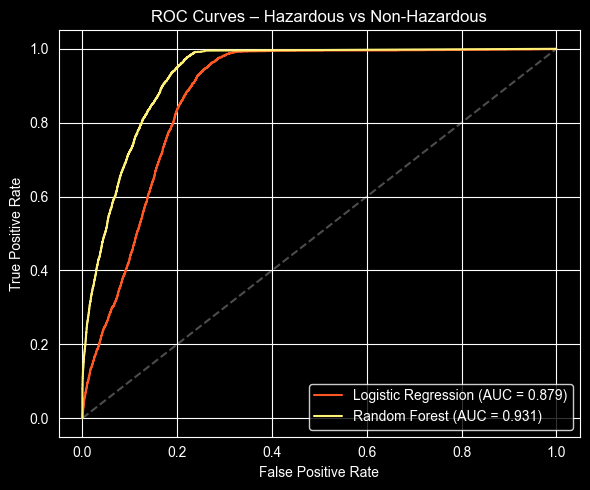

In [16]:
# ROC curves and AUC values

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# AUC values
auc_logit = roc_auc_score(y_test, y_proba_logit)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# ROC curves
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_proba_logit)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

space_colors = ["#ffb74d", "#ff9800", "#ff5722", "#ffca28", "#fff176", "#fbc02d"]

plt.figure(figsize=(6, 5), facecolor="black")
ax = plt.gca()

ax.plot(fpr_logit, tpr_logit, color=space_colors[2],
        label=f"Logistic Regression (AUC = {auc_logit:.3f})")
ax.plot(fpr_rf, tpr_rf, color=space_colors[4],
        label=f"Random Forest (AUC = {auc_rf:.3f})")

ax.plot([0, 1], [0, 1], "w--", alpha=0.3)  # diagonal

ax.set_facecolor("black")
ax.set_title("ROC Curves – Hazardous vs Non-Hazardous", color="white")
ax.set_xlabel("False Positive Rate", color="white")
ax.set_ylabel("True Positive Rate", color="white")
ax.tick_params(colors="white")

for spine in ax.spines.values():
    spine.set_color("white")

ax.legend(facecolor="black", edgecolor="white", labelcolor="white")

plt.tight_layout()
plt.show()



## 4. Model Evaluation and Comparison

🌟 Interpretation of the Logistic Regression Model: <br>

Logistic Regression reaches around 90% test accuracy, but it mainly achieves this by predicting “non-hazardous” most of the time. Recall for the hazardous class is only about 7–8%, which means the model misses the large majority of dangerous asteroids. Accuracy alone is clearly misleading here because of the class imbalance.
The additional tuning (C parameter and class_weight) had only a very minor
influence on Logistic Regression. This is expected: the model is linear and too
simple for the structure in the asteroid data, so no amount of class weighting
can fix the limited separability. <br>

🌟 Interpretation of the Random Forest Model: <br>

The Random Forest picks up nonlinear patterns (like “big + bright + close = risky”) that the linear model simply couldn’t. <br>
For the non-hazardous class, performance is extremely strong: the model correctly identifies 98% of all true non-hazardous asteroids (recall) and is correct 93% of the time when predicting this class (precision). The forest is amazing at not sounding false alarms! <br>
For the hazardous class, performance is understandably lower because that class is only about 10% of the data, but still much better than the logistic model. The model catches around 37% of all real hazardous objects (recall), and when it predicts “hazardous,” it is correct about 62% of the time (precision). Compared to the logistic model which barely detected anything, this is a great improvement. <br>

🌙 Interpretation of the ROC Curves: <br>

The ROC curves make the comparison even clearer. The Random Forest curve rises sharply up the left edge with an AUC around 0.93, while the logistic regression curve stays lower with an AUC around 0.88. This means the Random Forest is much better at ranking asteroids from “harmless” to “not so harmless”. <br>
Across all possible threshold choices, the forest consistently separates the two classes better. If NASA wanted to adjust the cutoff to be more cautious and label more borderline objects as hazardous, the forest would give them more flexibility and still strong performance. <br>

## 5. Discussion and Conclusion

## 🌍 Does this mean NASA misses 63% of hazardous asteroids?

Not at all, this is simply what my tiny model manages to recover from a very limited set of columns. My Random Forest is doing its absolute best with the features provieded. NASA, on the other hand, uses rocket science. Literally. <br>
It’s important to understand what the recall number truly represents. My model is not detecting asteroids in real life, but it is only trying to imitate NASA’s “hazardous” label from this simplified tabular dataset. NASA’s actual classification process is a whole different universe: complex orbit simulations, long-term trajectory projections, uncertainty propagation, radar follow-ups, infrared observations, and real astrophysicists. <br>
So when my model catches 37% of the hazardous objects, it simply means: “given only these features, I can reproduce 37% of NASA’s decisions.” It does not mean NASA is missing 63% of dangerous asteroids. The gap is a limitation of this dataset, not of NASA’s planetary-defense system.


In [17]:
# counts from the test set
n_test      = len(y_test)
n_true_haz  = (y_test == 1).sum()
n_pred_haz  = (y_pred_rf == 1).sum()

tn, fp, fn, tp = cm_rf.ravel()

share_hazards = n_true_haz / n_test
share_caught = tp / n_true_haz
share_missed = fn / n_true_haz
share_pred_hazards = n_pred_haz / n_test

p_mean = y_proba_rf.mean()
biggest = df.loc[df["est_diameter_max"].idxmax(), feature_columns]
p_big = rf_model.predict_proba(pd.DataFrame([biggest]))[0, 1]

print("🎙️ INTERVIEW WITH A RANDOM FOREST")
print("--------------------------------------------------")
print("Q: How many near-Earth objects did you look at?")
print(f"A: I examined {n_test:,} objects in the test set.")
print()
print("Q: And how many of those are actually labeled hazardous?")
print(f"A: {n_true_haz:,} of them are hazardous, that's {share_hazards:.2%} of everything I saw.")
print()
print("Q: How often did you raise an alarm?")
print(f"A: I shouted hazardous! for {n_pred_haz:,} objects, {share_pred_hazards:.2%} of the test set.")
print()
print("Q: Did you at least catch some of the truly dangerous ones?")
print(f"A: Yes! I correctly flagged {tp:,} hazardous objects which is {share_caught:.1%} of all the real hazards.")
print()
print("Q: Hmmm okay... and how many slipped past you?")
print(f"A: I have to admit I quietly let {fn:,} hazardous objects go by, which is {share_missed:.1%} of the actual hazards, sorryyyy.")
print()
print("Q: On average, how risky do you think these objects are?")
print(f"A: Across the whole test set, I assign an average hazard probability of about {p_mean:.2%} per object.")
print()
print("Q: And what about the single largest rock in the dataset?")
print(f"A: For the biggest one I saw, I estimate a hazard probability of {p_big:.2%}. Definitely one to keep an eye on.")
print()
print("Q: So... can I trust you?")
print("A: I'm literally a trained model, so I'm biased by design.")



🎙️ INTERVIEW WITH A RANDOM FOREST
--------------------------------------------------
Q: How many near-Earth objects did you look at?
A: I examined 27,251 objects in the test set.

Q: And how many of those are actually labeled hazardous?
A: 2,652 of them are hazardous, that's 9.73% of everything I saw.

Q: How often did you raise an alarm?
A: I shouted hazardous! for 1,583 objects, 5.81% of the test set.

Q: Did you at least catch some of the truly dangerous ones?
A: Yes! I correctly flagged 976 hazardous objects which is 36.8% of all the real hazards.

Q: Hmmm okay... and how many slipped past you?
A: I have to admit I quietly let 1,676 hazardous objects go by, which is 63.2% of the actual hazards, sorryyyy.

Q: On average, how risky do you think these objects are?
A: Across the whole test set, I assign an average hazard probability of about 9.91% per object.

Q: And what about the single largest rock in the dataset?
A: For the biggest one I saw, I estimate a hazard probability of 11.5

## Conclusion 💫

Okay, now I let the Random Forest curl up under a space blanket and enjoy the little moment of glory it earned today. I officially picked it as my final model over Logistic Regression, not out of favoritism, but simply because its performance was clearly better for this task. It understood the nonlinear “big + bright + close = risky” pattern in a way the linear model just couldn’t. <br>
Overall, this project made me realize how cool it is that we can take a handful of simple features and build a model that starts to mimic NASA’s risk labeling. The fact that the forest can already detect more than a third of the hazardous objects is honestly kind of impressive. It makes me imagine what would be possible with a richer, more up-to-date dataset with more orbital parameters, uncertainty measures, thermal effects, radar data, or even long-term trajectory simulations. <br>
With more features and more observations, one could push this much further. A bigger dataset could support more advanced models, maybe even a full neural network. And if I wanted to take this deeper, I could explore NASA’s actual risk-assessment systems like Sentry II, which use orbital mechanics and massive simulations to track hazards decades into the future. It’s a whole universe of methods, and this project was just my first small launch into it. <br>
So yes, my model definitely not saving the planet anytime soon, but it shows the promise and possibilities of machine learning in planetary defense, and that alone feels like a tiny success 💫

## Appendix: AI Assistance Protocol

**Prompt 1:**
I am a bit confused about the `absolute_magnitude` column in my dataset.
I know that in astronomy the magnitude scale is kind of reversed, but I don't
fully understand how this value is determined or how it relates to the actual
size of an asteroid. Could you explain in simple terms what absolute magnitude
means, why lower values correspond to brighter/larger objects, and how I can
mention this clearly in my project? <br>
--> **AI assistance:** Explained that absolute magnitude is a brightness measure on a reverse scale (lower value = brighter object), and that brighter asteroids are typically larger or more reflective. Clarified how this links to estimated diameter and why hazardous asteroids tend to have lower absolute magnitude values.

**Prompt 2:**
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    df[col].hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
could we make this appear as side by side plots so it is smaller and make it look like space like maybe orange black colors?
I am doing a project on a space dataset. Is it possible for the background to be black and then the bars to appear orange/ sun/ planet colors? <br>
--> **AI assistance:** Provided code to generate a grid of histograms with a black space-themed background and warm orange/yellow colors.

**Prompt 3:**
How do I fix this warning: Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.  <br>
--> **AI assistance:** Explained the seaborn warning and provided updated boxplot code with proper hue handling.

**Prompt 4**
I'm trying to make all my plots look space-themed. Could you give me a small palette of hex colors that look like planets, sunsets, asteroids? Ideally warm orange/yellow tones that still pop on a black background.
--> **AI Assistance**: Provided suggestions of colors.  <br>

**Prompt 5:**
How do I fix the scaling of the first boxplot in this code?
The values look super compressed.  <br>
--> **AI assistance:** Suggested using a log scale for the y-axis and provided the adjusted code snippet.

**Prompt 6:**
How could I theoretically plot a logistic curve to see how the logistic
regression model behaves? I want a plot showing how predicted hazard probability
changes with absolute magnitude, using my existing model and my dataset.  <br>
--> **AI assistance:** Provided a code snippet to compute and plot the logistic curve for absolute magnitude.

**Prompt 7:**
What should I tune for logistic regression?
Does it make sense to just set class_weight="balanced"?
What hyperparameters are sensible for logisitc regression?  <br>
--> **AI assistance:** Recommended tuning C and class_weight, and provided a small sklearn GridSearchCV setup.

**Prompt 8**
How exactly does NASA determine hazardous objects with machine learning models, what extra features do they use, and what all those orbit terms like MOID or trajectory simulations mean I stumbled upon. How can I phrase this clearly in a report?  <br>
--> **AI assistance:** Provided a short clarification of NASA using complex orbital simulations, uncertainty modeling, updated observations, and many additional parameters.  <br>

## Additional Sources
Source: NASA (2021), “NASA’s Next-Generation Asteroid Impact Monitoring System Goes Online.”
https://www.nasa.gov/solar-system/nasas-next-generation-asteroid-impact-monitoring-system-goes-online/ <br>

Source: NASA JPL, "Asteroid Size Estimation"  
https://cneos.jpl.nasa.gov/tools/ast_size_est.html


